In [0]:
import scipy
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve
import scipy.signal as signal
from google.colab import files

In [2]:
uploaded = files.upload()

Saving bean.jpg to bean.jpg
Saving mask_2.bmp to mask_2.bmp
Saving mask_3.bmp to mask_3.bmp
Saving mask_bean.bmp to mask_bean.bmp
Saving source_2.jpg to source_2.jpg
Saving source_3.jpg to source_3.jpg
Saving target_2.jpg to target_2.jpg
Saving target_3.jpg to target_3.jpg


In [0]:
def getIndexes(mask, targetH, targetW, offsetX=0, offsetY=0):
    """ Creates indexes in the target image, each replacement pixel in the
    target image would get index starting from 1, other pixels get 0 in the indexes.

    Args:
    mask: SrcH * SrcW, logical mask of source image
    targetH, targetW: int, height and width of target image
    offsetX, offsetY: int, offset of replacement pixel area from source to target

    Return:
    indexes: targetH * targetW, indexes of target image
    """
    # IMPLEMENT HERE
    # you might find numpy.meshgrid and numpy.arange useful
    SrcH, SrcW = mask.shape[0], mask.shape[1]
    indexes = np.zeros((targetH, targetW), dtype=int)

    idx = 0
    for j in range(SrcH):
      for i in range(SrcW):
        if (mask[j, i] > 0):
          idx += 1
          indexes[j + offsetY, i + offsetX] = idx
          
    return indexes

In [0]:
def getCoefficientMatrix(indexes):
  """
  constructs the coefficient matrix(A in Ax=b)
  
  Args: 
  indexes: targetH * targetW, indexes of target image starting from 1, 0 if not in target area 
  
  returns:
  coeffA: N * N(N is max index), a matrix corresponds to laplacian kernel, 4 on the diagonal and -1 for each neighbor
  """
  # IMPLEMENT HERE
  # the coefficient matrix is by nature sparse. consider using scipy.sparse.csr_matrix
  N = np.max(indexes)
  coeffA = sparse.lil_matrix((N, N), dtype=int)  # more efficient than np.zeros

  arg_list = np.argwhere(indexes > 0)
  for j, i in arg_list:
    row = indexes[j, i] - 1
    coeffA[row, row] = 4
    p1 = indexes[j - 1, i]
    p2 = indexes[j + 1, i]
    p3 = indexes[j, i - 1]
    p4 = indexes[j, i + 1]
    if (p1 > 0):
      coeffA[row, p1 - 1] = -1
    if (p2 > 0):
      coeffA[row, p2 - 1] = -1
    if (p3 > 0):
      coeffA[row, p3 - 1] = -1
    if (p4 > 0):
      coeffA[row, p4 - 1] = -1

  coeffA = sparse.csr_matrix(coeffA)

  return coeffA

In [0]:
def getSolutionVect(indexes, source, target, offsetX, offsetY):
    """
    constructs the target solution vector(b in Ax=b) 
    
    Args:
    indexes:  targetH * targetW, indexes of replacement area
    source, target: source and target image
    offsetX, offsetY: offset of source image origin in the target image

    Returns:
    solution vector b (for single channel)
    """
    # IMPLEMENT HERE
    # 1. get Laplacian part of b from source image
    N = np.max(indexes)
    SrcH, SrcW = source.shape[0], source.shape[1]
    targetH, targetW = target.shape[0], target.shape[1]

    kernel = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]])
    conv_src = signal.convolve2d(source, kernel, mode='same')

    temp_src = np.zeros((targetH, targetW))
    temp_src[offsetY:offsetY + SrcH, offsetX:offsetX + SrcW] = conv_src

    b_s = np.zeros(N)
    idx = 0
    for j in range(targetH):
      for i in range(targetW):
        if (indexes[j, i] > 0):
          b_s[idx] = temp_src[j, i]
          idx += 1
    
    # 2. get pixel part of b from target image
    b_t = np.zeros(N)
    arg_list = np.argwhere(indexes > 0)
    for j, i in arg_list:
      row = indexes[j, i] - 1
      p1 = indexes[j - 1, i]
      p2 = indexes[j + 1, i]
      p3 = indexes[j, i - 1]
      p4 = indexes[j, i + 1]
      if (p1 == 0):
        b_t[row] += target[j - 1, i]
      if (p2 == 0):
        b_t[row] += target[j + 1, i]
      if (p3 == 0):
        b_t[row] += target[j, i - 1]
      if (p4 == 0):
        b_t[row] += target[j, i + 1]

    # 3. add two parts together to get b
    b = b_s + b_t
    
    return b

In [0]:
def solveEqu(A, b):
  """
  solve the equation Ax = b to get replacement pixels x in the replacement area
  Note: A is a sparse matrix, so we need to use coresponding function to solve it

  Args:
  - A: Laplacian coefficient matrix
  - b: target solution vector
  
  Returns:
  - x: solution of Ax = b
  """
  # IMPLEMENT HERE
  # you may find scipy.sparse.linalg.spsolve 
  x = spsolve(A, b)

  return x

In [0]:
def reconstructImg(indexes, red, green, blue, targetImg):
    """
    reconstruct the target image with new red, green, blue channel values in th
    e indexes area

    red, green, blue: 1 x N, three chanels for replacement pixels
    """
    # 1. get nonzero component in indexes
    # use numpy copy from part 1 in order to make sure of the numpy copy in part 3
    targetImg_r = np.copy(targetImg[:, :, 0])
    targetImg_g = np.copy(targetImg[:, :, 1])
    targetImg_b = np.copy(targetImg[:, :, 2])
    
    arg_list = np.argwhere(indexes > 0)
    for j, i in arg_list:
      row = indexes[j, i] - 1
      targetImg_r[j, i] = red[row]
      targetImg_g[j, i] = green[row]
      targetImg_b[j, i] = blue[row]

    # 2. stack three channels together with numpy dstack
    tempImg = np.dstack((targetImg_r, targetImg_g, targetImg_b))

    # 3. copy new pixels in the indexes area to the target image 
    # use numpy copy to make a copy of targetImg, otherwise the original targetImg might change, too
    copyImg = np.copy(tempImg)

    return copyImg

In [0]:
"""
Function (do not modify)
"""
def seamlessCloningPoisson(sourceImg, targetImg, mask, offsetX, offsetY):
    """
    Wrapper function to put all steps together
    Args:
    - sourceImg, targetImg: source and targe image
    - mask: masked area in the source image
    - offsetX, offsetY: offset of the mask in the target image
    Returns:
    - ResultImg: result image
    """
    # step 1: index replacement pixels
    indexes = getIndexes(mask, targetImg.shape[0], targetImg.shape[1], offsetX,
                         offsetY)
    # step 2: compute the Laplacian matrix A
    A = getCoefficientMatrix(indexes)

    # step 3: for each color channel, compute the solution vector b
    red, green, blue = [
        getSolutionVect(indexes, sourceImg[:, :, i], targetImg[:, :, i],
                        offsetX, offsetY).T for i in range(3)
    ]

    # step 4: solve for the equation Ax = b to get the new pixels in the replacement area
    new_red, new_green, new_blue = [
        solveEqu(A, channel)
        for channel in [red, green, blue]
    ]

    # step 5: reconstruct the image with new color channel
    resultImg = reconstructImg(indexes, new_red, new_green, new_blue,
                               targetImg)
    return resultImg

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


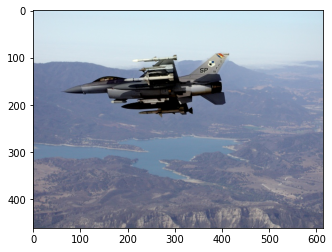

In [9]:
"""
Script (do not modify)
"""
src_path = 'source_3.jpg'
src = np.array(Image.open(src_path).convert('RGB'), 'f') / 255
target_path  ='target_3.jpg'
target = np.array(Image.open(target_path).convert('RGB'), 'f') / 255
offsetX = 40
offsetY = 20
mask_path = 'mask_3.bmp'
mask = np.array(Image.open(mask_path)) > 0
result = seamlessCloningPoisson(src, target, mask, offsetX, offsetY)
plt.imshow(result)
plt.show()
cloned = Image.fromarray((np.clip(result, 0, 1) * 255).astype(np.uint8))
cloned.save('cloned.png')
files.download('cloned.png')

In [0]:
def getSolutionVectMixing(indexes, source, target, offsetX, offsetY):
    """
    constructs the target solution vector(b in Ax=b) 
    
    Args:
    indexes:  targetH * targetW, indexes of replacement area
    source, target: source and target image
    offsetX, offsetY: offset of source image origin in the target image

    Returns:
    solution vector b (for single channel)
    """
    # IMPLEMENT HERE
    # almost the same as getSolutionVect, need to change the Laplacian part of b
    # 1. get Laplacian part of b from source image
    N = np.max(indexes)
    SrcH, SrcW = source.shape[0], source.shape[1]
    source_pad = np.pad(source, (1, 1), mode='constant', constant_values=0)
    targetH, targetW = target.shape[0], target.shape[1]
    
    # From the Project VI note, "2 Mixing Gradients"
    mixing_src = np.zeros((SrcH, SrcW))
    for j in range(SrcH):
      for i in range(SrcW):
        # gi = gi_p - gi_q, i = 1, 2, 3, 4
        g1 = source_pad[j, i] - source_pad[j - 1, i]
        g2 = source_pad[j, i] - source_pad[j + 1, i]
        g3 = source_pad[j, i] - source_pad[j, i - 1]
        g4 = source_pad[j, i] - source_pad[j, i + 1]
        # fi = fi_p^star - fi_q^star, i = 1, 2, 3, 4
        f1 = target[offsetY + j, offsetX + i] - target[offsetY + j - 1, offsetX + i]
        f2 = target[offsetY + j, offsetX + i] - target[offsetY + j + 1, offsetX + i]
        f3 = target[offsetY + j, offsetX + i] - target[offsetY + j, offsetX + i - 1]
        f4 = target[offsetY + j, offsetX + i] - target[offsetY + j, offsetX + i + 1]
        # fi if fi >= gi; gi if fi < gi
        if (np.abs(f1) >= np.abs(g1)):
          mixing_src[j, i] += f1
        else:
          mixing_src[j, i] += g1
        if (np.abs(f2) >= np.abs(g2)):
          mixing_src[j, i] += f2
        else:
          mixing_src[j, i] += g2
        if (np.abs(f3) >= np.abs(g3)):
          mixing_src[j, i] += f3
        else:
          mixing_src[j, i] += g3
        if (np.abs(f4) >= np.abs(g4)):
          mixing_src[j, i] += f4
        else:
          mixing_src[j, i] += g4
    
    temp_src = np.zeros((targetH, targetW))
    temp_src[offsetY:offsetY + SrcH, offsetX:offsetX + SrcW] = mixing_src
    
    b_s = np.zeros(N)
    idx = 0
    for j in range(targetH):
      for i in range(targetW):
        if (indexes[j, i] > 0):
          b_s[idx] = temp_src[j, i]
          idx += 1
    
    # 2. get pixel part of b from target image
    b_t = np.zeros(N)
    arg_list = np.argwhere(indexes > 0)
    for j, i in arg_list:
      row = indexes[j, i] - 1
      p1 = indexes[j - 1, i]
      p2 = indexes[j + 1, i]
      p3 = indexes[j, i - 1]
      p4 = indexes[j, i + 1]
      if (p1 == 0):
        b_t[row] += target[j - 1, i]
      if (p2 == 0):
        b_t[row] += target[j + 1, i]
      if (p3 == 0):
        b_t[row] += target[j, i - 1]
      if (p4 == 0):
        b_t[row] += target[j, i + 1]

    # 3. add two parts together to get b
    b = b_s + b_t
    
    return b

In [0]:
"""
Function (do not modify)
"""
def PoissonMixing(sourceImg, targetImg, mask, offsetX, offsetY):
    """
    Wrapper function to put all steps together
    Args:
    - sourceImg, targetImg: source and target image
    - mask: masked area in the source image
    - offsetX, offsetY: offset of the mask in the target image
    Returns:
    - ResultImg: result image
    """
    # step 1: index replacement pixels
    indexes = getIndexes(mask, targetImg.shape[0], targetImg.shape[1], offsetX,
                         offsetY)
    # step 2: compute the Laplacian matrix A
    A = getCoefficientMatrix(indexes)

    # step 3: for each color channel, compute the solution vector b
    red, green, blue = [
        getSolutionVectMixing(indexes, sourceImg[:, :, i], targetImg[:, :, i],
                        offsetX, offsetY).T for i in range(3)
    ]

    # step 4: solve for the equation Ax = b to get the new pixels in the replacement area
    new_red, new_green, new_blue = [
        solveEqu(A, channel)
        for channel in [red, green, blue]
    ]

    # step 5: reconstruct the image with new color channel
    resultImg = reconstructImg(indexes, new_red, new_green, new_blue,
                               targetImg)
    return resultImg

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


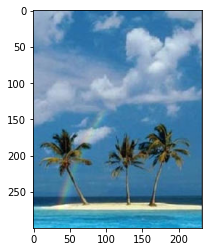

In [12]:
"""
Script (do not modify)
"""
src_path = 'source_2.jpg'
src = Image.open(src_path).convert('RGB')

src = np.array(src, 'f') / 255
target_path  ='target_2.jpg'
target = Image.open(target_path).convert('RGB')
target = np.array(target, 'f') / 255
offsetX = 10
offsetY = 130
mask_path = 'mask_2.bmp'
mask = Image.open(mask_path)
mask =np.array(mask) > 0
result = PoissonMixing(src, target, mask, offsetX, offsetY)
plt.imshow(result)
plt.show()
mixed = Image.fromarray((np.clip(result, 0, 1) * 255).astype(np.uint8))
mixed.save('mixed.png')
files.download('mixed.png')

In [0]:
def getSolutionVectTexture(indexes, target, mask, edges):
    """
    constructs the target solution vector(b in Ax=b) 
    
    Args:
    indexes:  targetH * targetW, indexes of replacement area
    target: target image
    edges: edge map of the target image

    Returns:
    solution vector b (for single channel)
    """
    # IMPLEMENT HERE
    # almost the same as getSolutionVect, need to change the Laplacian part of b
    # 1. get Laplacian part of b from source image
    N = np.max(indexes)
    SrcH, SrcW = mask.shape[0], mask.shape[1]
    targetH, targetW = target.shape[0], target.shape[1]
    target_pad = np.pad(target, (1, 1), mode='constant', constant_values=0)
    edges_pad = np.pad(edges, (1, 1), mode='constant', constant_values=0)
    offsetX, offsetY = 0, 0
    
    # From the Project VI note, "3 Texture Flattening"
    flatten_src = np.zeros((SrcH, SrcW))
    for j in range(SrcH):
      for i in range(SrcW):
        # fi = fi_p^star - fi_q^star, i = 1, 2, 3, 4
        '''
        f1 = target_pad[j, i] - target_pad[j - 1, i]
        f2 = target_pad[j, i] - target_pad[j + 1, i]
        f3 = target_pad[j, i] - target_pad[j, i - 1]
        f4 = target_pad[j, i] - target_pad[j, i + 1]
        '''
        # fi if M_p = 1 or M_q = 1
        if (edges_pad[j, i] == 1 or edges_pad[j - 1, i] == 1):
          flatten_src[j, i] += target_pad[j, i] - target_pad[j - 1, i]  # f1
        if (edges_pad[j, i] == 1 or edges_pad[j + 1, i] == 1):
          flatten_src[j, i] += target_pad[j, i] - target_pad[j + 1, i]  # f2
        if (edges_pad[j, i] == 1 or edges_pad[j, i - 1] == 1):
          flatten_src[j, i] += target_pad[j, i] - target_pad[j, i - 1]  # f3
        if (edges_pad[j, i] == 1 or edges_pad[j, i + 1] == 1):
          flatten_src[j, i] += target_pad[j, i] - target_pad[j, i + 1]  # f4
    
    temp_src = np.zeros((targetH, targetW))
    temp_src[offsetY:offsetY + SrcH, offsetX:offsetX + SrcW] = flatten_src
    
    b_s = np.zeros(N)
    idx = 0
    for j in range(targetH):
      for i in range(targetW):
        if (indexes[j, i] > 0):
          b_s[idx] = temp_src[j, i]
          idx += 1
    
    # 2. get pixel part of b from target image
    b_t = np.zeros(N)
    arg_list = np.argwhere(indexes > 0)
    for j, i in arg_list:
      row = indexes[j, i] - 1
      p1 = indexes[j - 1, i]
      p2 = indexes[j + 1, i]
      p3 = indexes[j, i - 1]
      p4 = indexes[j, i + 1]
      if (p1 == 0):
        b_t[row] += target[j - 1, i]
      if (p2 == 0):
        b_t[row] += target[j + 1, i]
      if (p3 == 0):
        b_t[row] += target[j, i - 1]
      if (p4 == 0):
        b_t[row] += target[j, i + 1]

    # 3. add two parts together to get b
    b = b_s + b_t
    
    return b

In [0]:
"""
Function (do not modify)
"""
def PoissonTextureFlattening(targetImg, mask, edges):
    """
    Wrapper function to put all steps together
    Args:
    - targetImg: target image
    - mask: masked area in the source image
    - offsetX, offsetY: offset of the mask in the target image
    Returns:
    - ResultImg: result image
    """
    # step 1: index replacement pixels
    indexes = getIndexes(mask, targetImg.shape[0], targetImg.shape[1])
    # step 2: compute the Laplacian matrix A
    A = getCoefficientMatrix(indexes)

    # step 3: for each color channel, compute the solution vector b
    red, green, blue = [
        getSolutionVectTexture(indexes, targetImg[:, :, i], mask, edges).T for i in range(3)
    ]

    # step 4: solve for the equation Ax = b to get the new pixels in the replacement area
    new_red, new_green, new_blue = [
        solveEqu(A, channel)
        for channel in [red, green, blue]
    ]

    # step 5: reconstruct the image with new color channel
    resultImg = reconstructImg(indexes, new_red, new_green, new_blue,
                               targetImg)
    return resultImg

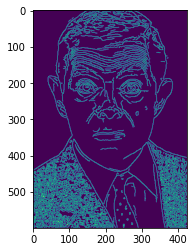

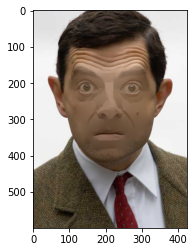

In [15]:
"""
Script (do not modify)
"""
target_path  ='bean.jpg'
target = np.array(Image.open(target_path).convert('RGB'), 'f') / 255
from skimage.color import rgb2gray
from skimage import feature
edges = feature.canny(rgb2gray(target))
plt.imshow(edges)
plt.show()
mask_path = 'mask_bean.bmp'
mask = np.array(Image.open(mask_path)) > 0
result = PoissonTextureFlattening(target, mask, edges)
plt.imshow(result)
plt.show()
flatten = Image.fromarray((np.clip(result, 0, 1) * 255).astype(np.uint8))
flatten.save('flatten.png')
files.download('flatten.png')